1. Import Libraries and dependencies

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import mediapipe as mp

2. KeyPoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False                  
    results = model.process(image)                 
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) 
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) 
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) 

In [5]:
def draw_styled_landmarks(image, results):
    
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
      
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.8, min_tracking_confidence=0.8) as holistic:
    while cap.isOpened():

        
        ret, frame = cap.read()

       
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        
        draw_styled_landmarks(image, results)

       
        cv2.imshow('OpenCV Feed', image)

        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

3. Extract KeyPoints

In [7]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

4. SetUp Folders for Data Collection

In [8]:
DATA_PATH = os.path.join('MP_Data') 

actions = np.array(['Indian', 'Sign', 'Language', 'Man', 'Woman', 'Namaste', 'Deaf', 'Sorry', 'Happy', 'Sad', 'Understand', 'Bye', 'Please', 'Food', 'Water'])

no_sequences = 30

sequence_length = 30

start_folder = 30

In [9]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

5. Collect KeyPoints for training and testing

In [10]:
cap = cv2.VideoCapture(0)
 
with mp_holistic.Holistic(min_detection_confidence=0.8, min_tracking_confidence=0.8) as holistic:
    
   
    for action in actions:
      
        for sequence in range(no_sequences):
           
            for frame_num in range(sequence_length):

                
                ret, frame = cap.read()

                
                image, results = mediapipe_detection(frame, holistic)

                draw_styled_landmarks(image, results)
                
               
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,100), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,153, 0), 3, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (14,22), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 153), 2, cv2.LINE_AA)
                    
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(300)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (14,22), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 153), 2, cv2.LINE_AA)
                 
                    cv2.imshow('OpenCV Feed', image)
                
               
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

6. Preprocess Data and Create Labels and Features

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [12]:
label_map = {label:num for num, label in enumerate(actions)}

In [13]:
label_map

{'Indian': 0,
 'Sign': 1,
 'Language': 2,
 'Man': 3,
 'Woman': 4,
 'Namaste': 5,
 'Deaf': 6,
 'Sorry': 7,
 'Happy': 8,
 'Sad': 9,
 'Understand': 10,
 'Bye': 11,
 'Please': 12,
 'Food': 13,
 'Water': 14}

In [14]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [15]:
np.array(sequences).shape

(450, 30, 258)

In [16]:
X = np.array(sequences)

In [17]:
y = to_categorical(labels).astype(int)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [19]:
y_test.shape

(45, 15)

In [20]:
X_train.shape

(405, 30, 258)

7. Build and Train LSTM Neural Network

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [22]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [23]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(30,258)))
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [24]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=300, callbacks=[tb_callback])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           198144    
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 15)                4

8. Make Predictions

In [27]:
yhat = model.predict(X_test)

2/2 [==============================] - 1s 26ms/step


In [28]:
actions[np.argmax(yhat[4])]

'Food'

In [29]:
actions[np.argmax(y_test[4])]

'Food'

9. Save Weights

In [30]:
model.save('action.h5')

In [31]:
model.load_weights('action.h5')

10. Evaluation using Confusion Matrix and Accuracy

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [33]:
ytrue = np.argmax(y_test, axis=1)
yhat = np.argmax(yhat, axis=1)

In [34]:
cf_matrix = confusion_matrix(ytrue, yhat,labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])

In [35]:
cm = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=actions)

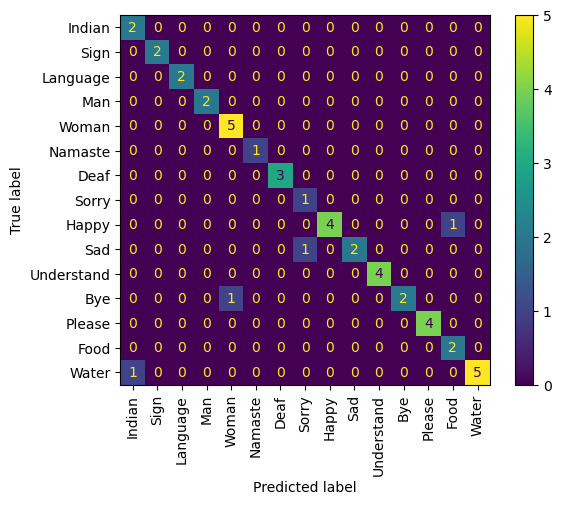

In [36]:
cm.plot(xticks_rotation='vertical')

In [37]:
cr = classification_report(ytrue, yhat)
print(cr)

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         3
           7       0.50      1.00      0.67         1
           8       1.00      0.80      0.89         5
           9       1.00      0.67      0.80         3
          10       1.00      1.00      1.00         4
          11       1.00      0.67      0.80         3
          12       1.00      1.00      1.00         4
          13       0.67      1.00      0.80         2
          14       1.00      0.83      0.91         6

    accuracy                           0.91        45
   macro avg       0.91      0.93      0.90        45
weighted avg       0.94   

In [38]:
accuracy_score(ytrue, yhat)

0.9111111111111111

11. Test in Real Time

In [ ]:
accuracy=[]
sequence = []
sentence = []
predictions = []
threshold = 0.9

cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.8, min_tracking_confidence=0.8) as holistic:
    while cap.isOpened():

     
        ret, frame = cap.read()

       
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
       
        draw_styled_landmarks(image, results)
        
        
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            # print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
        
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold:
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            # print(actions[np.argmax(res)])
                            sentence.append(actions[np.argmax(res)])
                            accuracy.append(str(round(int(res[np.argmax(res)]*100),2)))
                    else:
                        # print(actions[np.argmax(res)])
                        sentence.append(actions[np.argmax(res)])
                        accuracy.append(str(round(int(res[np.argmax(res)]*100),2)))

        if len(sentence) > 1: 
            sentence = sentence[-1:]
            accuracy = accuracy[-1:]
        
        string = str(sentence);  
        count = 0;  
        
        for i in range(0, len(string)):  
            if(string[i] != ' '):  
                count = count + 1
        
        if (count==7):
            count = count + 1
        elif (count==14):
            count = count - 2   

            
        cv2.rectangle(image, (0,0), (count*30, 40), (245, 117, 16), -1)
        cv2.putText(image,''.join(sentence)+' - '+''.join(accuracy)+'%', (15,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
       
        cv2.imshow('OpenCV Feed', image)

        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()